Importing Necessary Packages

In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation,concatenate, Attention, Bidirectional,GlobalAveragePooling1D
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import keras_tuner as kt
import math
from datetime import datetime, timedelta

Data Pull and Plot

In [4]:
start_date = '2016-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dates = data['Date']

'2024-01-09'

[*********************100%%**********************]  1 of 1 completed


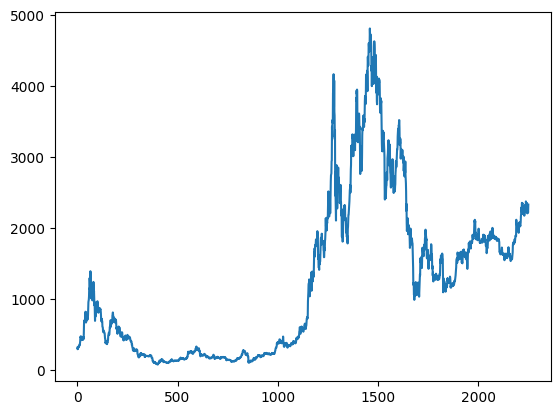

In [5]:
dataclose = data.reset_index()['Close']
plt.plot(dataclose)

In [6]:
scaler = MinMaxScaler()
dataclose = scaler.fit_transform(np.array(dataclose).reshape(-1,1))
dataclose.shape

(2252, 1)

In [7]:
train_size = int(len(dataclose)*0.65)
test_size = len(dataclose) - train_size
train_data,test_data = dataclose[0:train_size,:],dataclose[train_size:len(dataclose),:1]

In [8]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [9]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [10]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100

22/22 [==============================] - 6s 109ms/step - loss: 0.0164 - val_loss: 0.0052
Epoch 2/100
22/22 [==============================] - 2s 69ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 3/100
22/22 [==============================] - 2s 69ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/100
22/22 [==============================] - 2s 71ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 5/100
22/22 [==============================] - 2s 70ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
22/22 [==============================] - 2s 69ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/100
22/22 [==============================] - 2s 70ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/100
22/22 [==============================] - 1s 68ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/100
22/22 [==============================] - 2s 69ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
22/22 [==============================] - 2s 75ms/step - loss: 0.0012 - val_loss: 0.00

In [13]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

22/22 [==============================] - 0s 16ms/step


In [14]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [15]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

1326.2505451554262
1914.1422443811382


In [16]:
look_back = 100

In [17]:
trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [18]:
testPredictPlot = np.empty_like(dataclose)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(dataclose) - 1,:] = test_predict

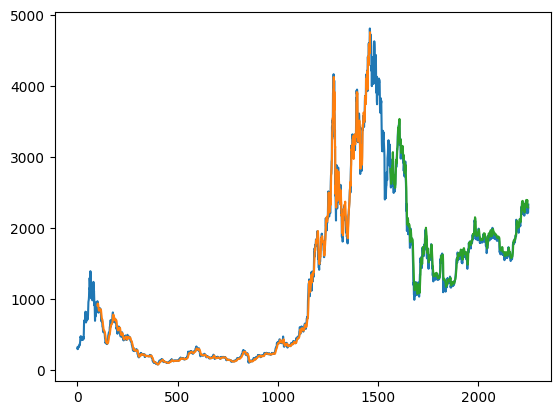

In [19]:
plt.plot(scaler.inverse_transform(dataclose))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [20]:
prediction_data = np.array(dataclose[-100:]).transpose()
prediction = scaler.inverse_transform(model.predict(prediction_data))
print("Prediction for: ", end_date, "        CLOSE: ", prediction[0][0])

1/1 [==============================] - 0s 21ms/step
Prediction for:  2024-01-09         CLOSE:  2324.5193
